<a href="https://colab.research.google.com/github/yehuda-yu/Tomato-Phosphorus-Image-Analysis/blob/main/Phosphorous_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io, feature, filters
from skimage.filters import threshold_multiotsu
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from google.colab.patches import cv2_imshow
from skimage.filters import threshold_otsu
from skimage.morphology import area_opening, disk, binary_closing
from scipy import ndimage as ndi
from scipy import stats
from skimage.measure import find_contours, label
import seaborn as sns
import os
plt.rcParams['axes.linewidth'] = 2
sns.set_theme(style="white",font_scale = 1.2)
sns.set_style("ticks")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Functions

Link to paper: https://www.mdpi.com/2071-1050/10/3/762

List of Indices (Include iPCA) https://www.sciencedirect.com/science/article/pii/S0303243414000762#bib0160

DGCI paper: https://acsess.onlinelibrary.wiley.com/doi/epdf/10.2135/cropsci2003.9430


In [ ]:
def calculate_relative_area(original_img, cropped_img):
    """
    Calculate the relative area of the cropped image to the original image.

    :param original_img: numpy array of the original image
    :param cropped_img: numpy array of the cropped image
    :return: float, relative area
    """
    original_pixels = original_img.shape[0] * original_img.shape[1]
    cropped_pixels = np.sum(~np.isnan(cropped_img[:,:,0]))
    return cropped_pixels / original_pixels

def calculate_texture(img, method='GLCM'):
    """
    Calculate texture features of an image using GLCM or Gabor filter.

    :param img: numpy array of the image
    :param method: string, 'GLCM' or 'Gabor'
    :return: dict of texture features
    """
    if img.shape[2] == 4:  # If image has an alpha channel
        img = img[:,:,:3]  # Remove the alpha channel

    gray_img = color.rgb2gray(img)

    if method == 'GLCM':
        glcm = feature.graycomatrix(np.uint8(gray_img*255), [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        features = {
            'contrast': feature.graycoprops(glcm, 'contrast')[0, 0],
            'dissimilarity': feature.graycoprops(glcm, 'dissimilarity')[0, 0],
            'homogeneity': feature.graycoprops(glcm, 'homogeneity')[0, 0],
            'energy': feature.graycoprops(glcm, 'energy')[0, 0],
            'correlation': feature.graycoprops(glcm, 'correlation')[0, 0]
        }
        return features
    elif method == 'Gabor':
        kernels = []
        for theta in range(4):
            theta = theta / 4. * np.pi
            for sigma in (1, 3):
                for frequency in (0.05, 0.25):
                    kernel = np.real(filters.gabor_kernel(frequency, theta=theta,
                                                          sigma_x=sigma, sigma_y=sigma))
                    kernels.append(kernel)

        feats = np.zeros((len(kernels), 2), dtype=np.double)
        for k, kernel in enumerate(kernels):
            filtered = ndi.convolve(gray_img, kernel, mode='wrap')
            feats[k, 0] = filtered.mean()
            feats[k, 1] = filtered.var()

        return {'gabor_features': feats.ravel()}
    else:
        raise ValueError("Method must be either 'GLCM' or 'Gabor'")

def extract_color_channels(img):
    """
    Extract RGB and HSV color channels from an image.

    :param img: numpy array of the image
    :return: tuple of numpy arrays (red, green, blue, hue, saturation, value)
    """
    if img.shape[2] == 4:  # If image has an alpha channel
        img = img[:,:,:3]  # Remove the alpha channel

    # Create a mask for non-NaN values
    mask = ~np.isnan(img).any(axis=2)

    # Apply the mask to all channels
    red = img[:,:,0][mask]
    green = img[:,:,1][mask]
    blue = img[:,:,2][mask]

    hsv_img = color.rgb2hsv(img)
    hue = hsv_img[:,:,0][mask]
    saturation = hsv_img[:,:,1][mask]
    value = hsv_img[:,:,2][mask]

    return red, green, blue, hue, saturation, value

def calculate_color_indices(red, green, blue, hue, saturation, value):
    """
    Calculate various color indices based on RGB and HSV values.

    :param red: numpy array of red channel values
    :param green: numpy array of green channel values
    :param blue: numpy array of blue channel values
    :param hue: numpy array of hue values
    :param saturation: numpy array of saturation values
    :param value: numpy array of value (brightness) values
    :return: dict of color indices, each containing all calculated values
    """
    # Brightness (BR)
    br = 0.3 * red + 0.6 * green + 0.1 * blue

    # Normalized indices
    rgb_sum = red + green + blue
    nri = red / rgb_sum
    ngi = green / rgb_sum
    nbi = blue / rgb_sum

    # Dark green color index (DGCI)
    dgci = ((hue - 60) / 60 + (1 - saturation) + (1 - value)) / 3

    # Green-red vegetation index (GRVI)
    grvi = (green - red) / (green + red)

    # Kawashima index (IKAW)
    ikaw = (red - blue) / (red + blue)

    # Principal component analysis index (IPCA)
    ipca = 0.994 * np.abs(red - blue) + 0.961 * np.abs(green - blue) + 0.914 * np.abs(green - red)

    return {
        'brightness': br,
        'nri': nri,
        'ngi': ngi,
        'nbi': nbi,
        'dgci': dgci,
        'grvi': grvi,
        'Ikaw': ikaw,
        'Ipca': ipca
    }


def create_image_dataset(image_paths, original_path, naming_dict):
    """
    Create a dataset from image analysis results with custom naming.
    Images are normalized based on the maximum value of the original image.

    :param image_paths: list of paths to cropped images
    :param original_path: path to the original image
    :param naming_dict: dictionary mapping numeric part of filename to new names
    :return: pandas DataFrame
    """
    # Read and process the original image
    original_img = io.imread(original_path)
    original_img = color.convert_colorspace(original_img, 'RGB', 'RGB')

    # Find the maximum value in the original image
    max_value = np.max(original_img)

    data = []
    for i, path in enumerate(image_paths):
        img = io.imread(path)
        if img.shape[2] == 4:  # If image has an alpha channel
            img = img[:,:,:3]  # Remove the alpha channel
        img = color.convert_colorspace(img, 'RGB', 'RGB')

        # Normalize the image based on the maximum value of the original image
        img = img / max_value

        img = np.where(img == 0, np.nan, img)

        relative_area = calculate_relative_area(original_img, img)
        red, green, blue, hue, saturation, value = extract_color_channels(img)
        texture_glcm = calculate_texture(img, method='GLCM')
        texture_gabor = calculate_texture(img, method='Gabor')
        # Extract color indices
        color_indices = calculate_color_indices(red, green, blue, hue, saturation, value)

        # Extract the numeric part from the filename
        filename = os.path.basename(path)
        numeric_part = ''.join(filter(str.isdigit, filename))

        # Use the naming dictionary to get the new name
        new_name = naming_dict.get(numeric_part, f"Unknown_{numeric_part}")

        row = {
            'path': path,
            'name': new_name,
            'serial_number': i+1,
            'relative_area': relative_area,
            'red': red.tolist(),
            'green': green.tolist(),
            'blue': blue.tolist(),
            'hue': hue.tolist(),
            'saturation': saturation.tolist(),
            'value': value.tolist(),
            **texture_glcm,
            **texture_gabor
        }

        # Add color indices to the row
        for index_name, index_values in color_indices.items():
            row[index_name] = index_values.tolist()

        data.append(row)

    return pd.DataFrame(data)

# define list of paths baes on all images in the folder
path_folder = '/content/drive/MyDrive/Phosphorus_project/Cropped_Images/'
image_paths = [path_folder + image_name for image_name in os.listdir(path_folder)]
# drop all the path that not ends with JPG
image_paths = [path for path in image_paths if path.endswith('.png')]
original_path = '/content/drive/MyDrive/Phosphorus_project/IMG_7015.JPG'
naming_dict = {'01': 'TSP', '02': 'Apa', '03': 'Apa@Muci', '04': 'PCP', '05': 'PCP@Muci'}
df = create_image_dataset(image_paths, original_path, naming_dict)
# df.to_csv('dataset.csv', index=False)


df

<ipython-input-44-52dd5ed3dad1>:27: RuntimeWarning: invalid value encountered in cast
  glcm = feature.graycomatrix(np.uint8(gray_img*255), [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])


,path,name,serial_number,relative_area,red,green,blue,hue,saturation,value,...,correlation,gabor_features,brightness,nri,ngi,nbi,dgci,grvi,Ikaw,Ipca
0,/content/drive/MyDrive/Phosphorus_project/Crop...,TSP,1,0.009236,"[0.5019607843137255, 0.4235294117647059, 0.415...","[0.3333333333333333, 0.40784313725490196, 0.40...","[0.16470588235294117, 0.26666666666666666, 0.2...","[0.08333333333333333, 0.15, 0.1544715447154471...","[0.671875, 0.37037037037037035, 0.386792452830...","[0.5019607843137255, 0.4235294117647059, 0.415...",...,0.978715,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.36705882352941177, 0.39843137254901956, 0.3...","[0.5019607843137256, 0.38571428571428573, 0.38...","[0.33333333333333337, 0.37142857142857144, 0.3...","[0.1647058823529412, 0.24285714285714288, 0.23...","[-0.057482298474945535, 0.06953340595497455, 0...","[-0.2018779342723005, -0.01886792452830189, -0...","[0.5058823529411766, 0.22727272727272727, 0.23...","[0.651407843137255, 0.3059294117647059, 0.3137..."
1,/content/drive/MyDrive/Phosphorus_project/Crop...,TSP,2,0.005146,"[0.42745098039215684, 0.43529411764705883, 0.4...","[0.42745098039215684, 0.4117647058823529, 0.42...","[0.28627450980392155, 0.2549019607843137, 0.25...","[0.16666666666666666, 0.14492753623188404, 0.1...","[0.3302752293577982, 0.41441441441441446, 0.39...","[0.42745098039215684, 0.43529411764705883, 0.4...",...,0.969811,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41333333333333333, 0.4031372549019608, 0.40...","[0.3745704467353952, 0.39501779359430605, 0.38...","[0.3745704467353952, 0.3736654804270462, 0.380...","[0.2508591065292096, 0.23131672597864766, 0.23...","[0.08168385600927423, 0.05090230895857495, 0.0...","[0.0, -0.02777777777777781, -0.009174311926605...","[0.19780219780219782, 0.2613636363636364, 0.25...","[0.27599999999999997, 0.35156078431372556, 0.3..."
2,/content/drive/MyDrive/Phosphorus_project/Crop...,TSP,3,0.006223,"[0.3333333333333333, 0.48627450980392156, 0.49...","[0.3333333333333333, 0.48627450980392156, 0.47...","[0.3333333333333333, 0.3333333333333333, 0.349...","[0.0, 0.16666666666666666, 0.14864864864864866...","[0.0, 0.3145161290322581, 0.2936507936507937, ...","[0.3333333333333333, 0.48627450980392156, 0.49...",...,0.975777,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.3333333333333333, 0.4709803921568627, 0.470...","[0.3333333333333333, 0.37237237237237236, 0.37...","[0.3333333333333333, 0.37237237237237236, 0.36...","[0.3333333333333333, 0.2552552552552552, 0.264...","[0.22222222222222224, 0.067329046313866, 0.071...","[0.0, 0.0, -0.016129032258064516, -0.008000000...","[0.0, 0.18660287081339716, 0.172093023255814, ...","[0.0, 0.29900000000000004, 0.282929411764706, ..."
3,/content/drive/MyDrive/Phosphorus_project/Crop...,Apa,4,0.004642,"[0.5019607843137255, 0.5725490196078431, 0.584...","[0.5019607843137255, 0.5725490196078431, 0.541...","[0.5019607843137255, 0.42745098039215684, 0.41...","[0.0, 0.16666666666666666, 0.12403100775193793...","[0.0, 0.2534246575342466, 0.28859060402684567,...","[0.5019607843137255, 0.5725490196078431, 0.584...",...,0.965904,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5019607843137255, 0.5580392156862745, 0.541...","[0.3333333333333333, 0.36408977556109723, 0.37...","[0.3333333333333333, 0.36408977556109723, 0.35...","[0.3333333333333333, 0.2718204488778055, 0.269...","[0.16601307189542483, 0.05893470021189603, 0.0...","[0.0, 0.0, -0.03832752613240424, -0.0530973451...","[0.0, 0.14509803921568626, 0.16862745098039217...","[0.0, 0.2836666666666666, 0.3276392156862745, ..."
4,/content/drive/MyDrive/Phosphorus_project/Crop...,Apa,5,0.006004,"[0.4235294117647059, 0.43529411764705883, 0.44...","[0.47843137254901963, 0.48627450980392156, 0.5...","[0.27450980392156865, 0.28627450980392155, 0.2...","[0.21153846153846156, 0.20915032679738563, 0.2...","[0.4262295081967213, 0.4112903225806452, 0.410...","[0.47843137254901963, 0.48627450980392156, 0.5...",...,0.969568,"[nan, nan, nan, na

In [ ]:
def perform_anova_analysis(df):
    """
    Perform ANOVA tests on raw color channels and texture parameters across different treatments.

    :param df: pandas DataFrame containing the image analysis results
    :return: DataFrame with ANOVA test results
    """
    # List of parameters for texture analysis
    texture_params = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    color_channels = ['red', 'green', 'blue', 'hue', 'saturation', 'value']
    color_indices = ['brightness', 'nri', 'ngi', 'nbi', 'dgci', 'grvi', 'Ikaw', 'Ipca']

    results = {}

    # Perform ANOVA for each color channel and texture parameter
    for param in texture_params + color_channels + color_indices:
        # Extract raw values for each group (based on 'name')
        groups = []
        for name in df['name'].unique():
            values = df[df['name'] == name][param].values

            # Ensure all values are at least 1D arrays before concatenation
            values = [v if np.ndim(v) > 0 else np.array([v]) for v in values]
            groups.append(np.concatenate(values))

        # Perform one-way ANOVA on the raw values
        f_value, p_value = stats.f_oneway(*groups)

        results[param] = {
            'F-statistic': f_value,
            'p-value': p_value
        }

    # Convert results to DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df['Significant'] = results_df['p-value'] < 0.05

    return results_df

# Perform ANOVA analysis
anova_results = perform_anova_analysis(df)

# Display the results
anova_results

# Optionally, save the results to a CSV file
# anova_results.to_csv('anova_results.csv')

,F-statistic,p-value,Significant
contrast,1.600197,0.248714,False
dissimilarity,0.509183,0.730635,False
homogeneity,1.065103,0.422863,False
energy,1.052306,0.428354,False
correlation,24.227554,0.000040,True
red,57384.988970,0.000000,True
green,61791.992642,0.000000,True
blue,18961.132137,0.000000,True
hue,2767.234387,0.000000,True
saturation,13107.333285,0.000000,True


<ipython-input-47-353589546cf4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='name', y=column, data=df.explode(column), ax=ax,
<ipython-input-47-353589546cf4>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


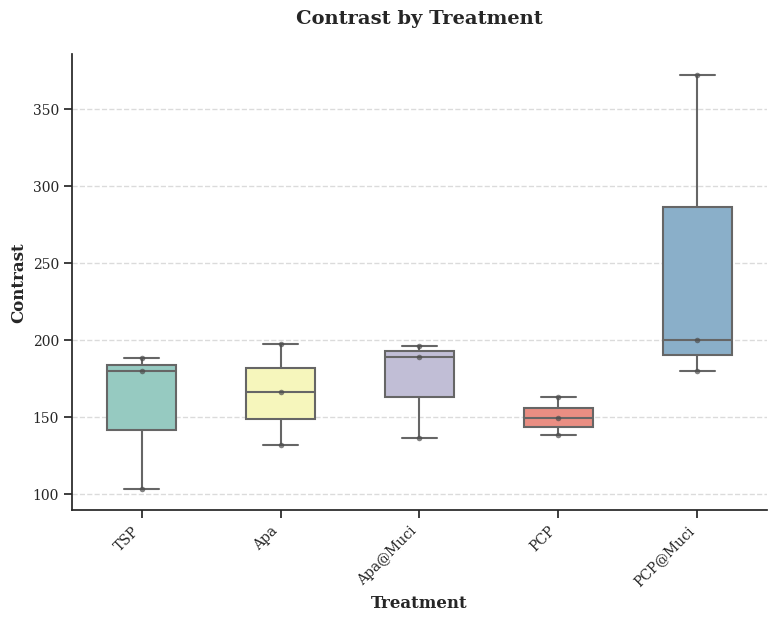

<ipython-input-47-353589546cf4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='name', y=column, data=df.explode(column), ax=ax,
<ipython-input-47-353589546cf4>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


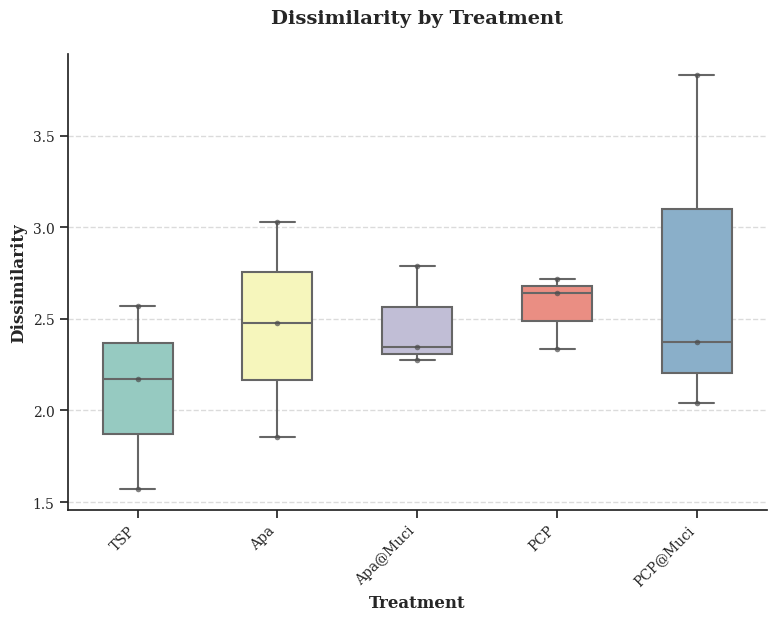

<ipython-input-47-353589546cf4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='name', y=column, data=df.explode(column), ax=ax,
<ipython-input-47-353589546cf4>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


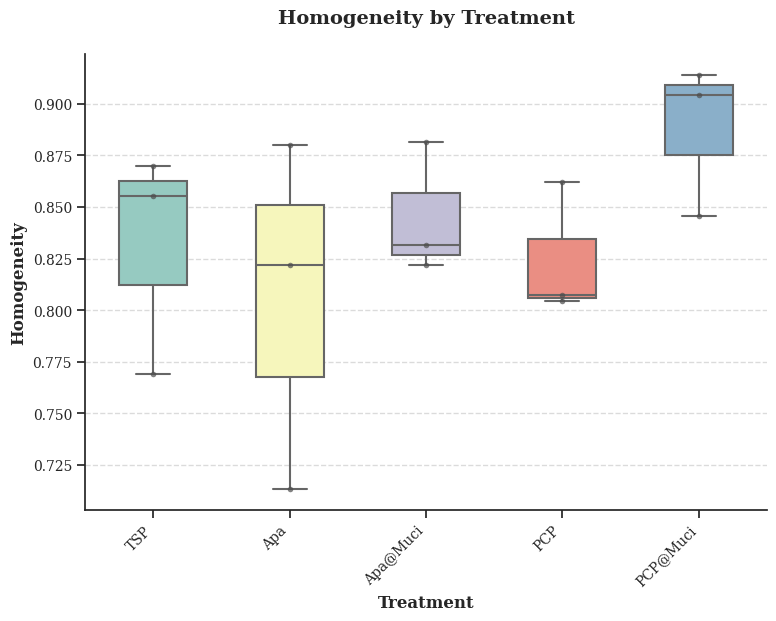

<ipython-input-47-353589546cf4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='name', y=column, data=df.explode(column), ax=ax,
<ipython-input-47-353589546cf4>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


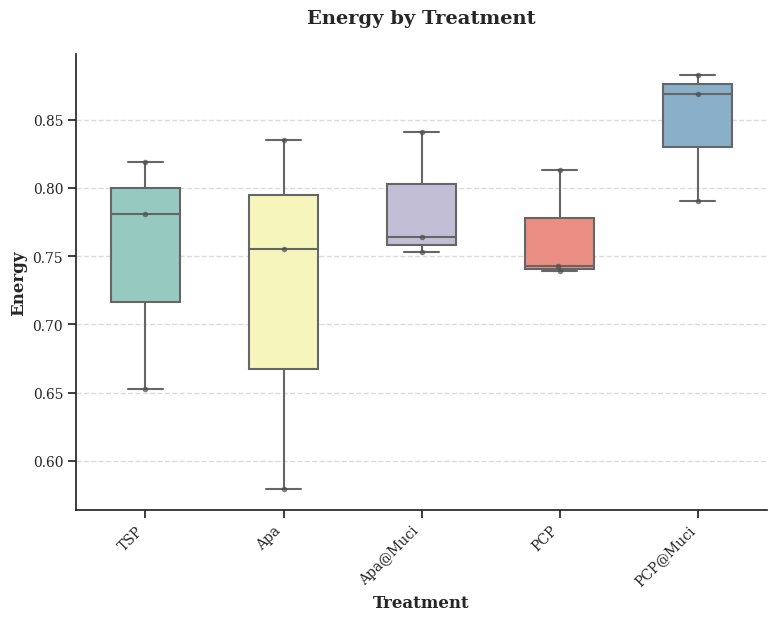

<ipython-input-47-353589546cf4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='name', y=column, data=df.explode(column), ax=ax,
<ipython-input-47-353589546cf4>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


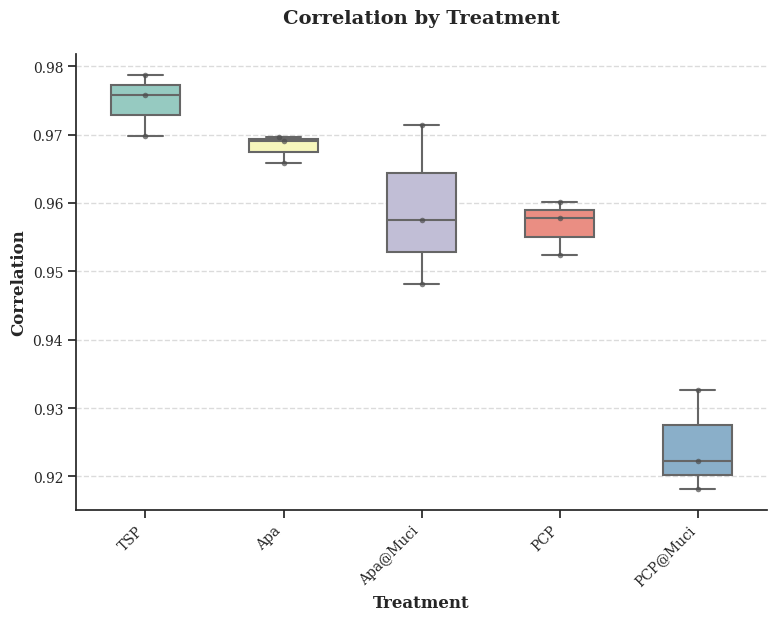

In [ ]:
from matplotlib.ticker import ScalarFormatter

def plot_publication_boxplot(df, column, output_path=None):
    """
    Create a publication-quality boxplot for a specified column.

    :param df: pandas DataFrame
    :param column: the column name to plot on the y-axis
    :param output_path: path to save the figure (optional)
    """
    # Set the style for the plot

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create the boxplot
    sns.boxplot(x='name', y=column, data=df.explode(column), ax=ax,
                width=0.5, palette='Set3', linewidth=1.5)

    # Add individual data points
    sns.swarmplot(x='name', y=column, data=df.explode(column), ax=ax,
                  color='0.3', size=4, alpha=0.7)

    # Customize the plot
    ax.set_xlabel('Treatment', fontsize=12, fontweight='bold')
    ax.set_ylabel(column.capitalize(), fontsize=12, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Use scientific notation for y-axis if values are very small
    if np.max(np.abs(df[column].explode())) < 0.01:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # Add a subtle grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout and add title
    plt.tight_layout()
    plt.title(f'{column.capitalize()} by Treatment', fontsize=14, fontweight='bold', y=1.05)

    # Save the figure if output_path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()

for param in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation',]:
    plot_publication_boxplot(df, param, f'boxplot_{param}.png')

In [ ]:
def plot_color_channel_boxplots(df, output_path=None):
    """
    Create publication-quality boxplots of red, green, and blue channels for each treatment.

    :param df: pandas DataFrame containing the image analysis results
    :param output_path: path to save the figure (optional)
    """
    # Set the style for the plot
    # plt.style.use('seaborn-whitegrid')

    # Create the figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    # fig.suptitle('Color Channel Distributions by Treatment', fontsize=16, fontweight='bold', y=0.95)

    colors = ['red', 'green', 'blue']

    for i, color in enumerate(colors):
        ax = axes[i]

        # Create the boxplot
        sns.boxplot(x='name', y=color, data=df.explode(color), ax=ax,
                    width=0.5, palette='Set3', linewidth=1.5)

        # Add individual data points
        # sns.swarmplot(x='name', y=color, data=df.explode(color), ax=ax,
        #               color='0.3', size=4, alpha=0.7)

        # Customize the plot
        ax.set_xlabel('Treatment', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'{color.capitalize()} Intensity', fontsize=12, fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Use scientific notation for y-axis if values are very small
        if np.max(np.abs(df[color].explode())) < 0.01:
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        # Add a subtle grid
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)

        # Add title to each subplot
        ax.set_title(f'{color.capitalize()} Channel by Treatment', fontsize=14, fontweight='bold', y=1.05)

    # Adjust layout
    plt.tight_layout()

    # Save the figure if output_path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()

# Call the function to create and display the plot
# plot_color_channel_boxplots(df, 'color_channel_boxplots.png')

### DGCI
**Meaning of Values**:
DGCI values range from 0 to 1.
0 indicates very yellow leaves
1 indicates dark green leaves

### GRVI
Green-red vegetation index (GRVI) is index to green/red ratio



<ipython-input-49-ec9a0e454499>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='name', y=index, data=df.explode(index), ax=ax,
<ipython-input-49-ec9a0e454499>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-49-ec9a0e454499>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='name', y=index, data=df.explode(index), ax=ax,
<ipython-input-49-ec9a0e454499>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-49-ec9a0e454499>:21: FutureWarning: 

Passing `palette` witho

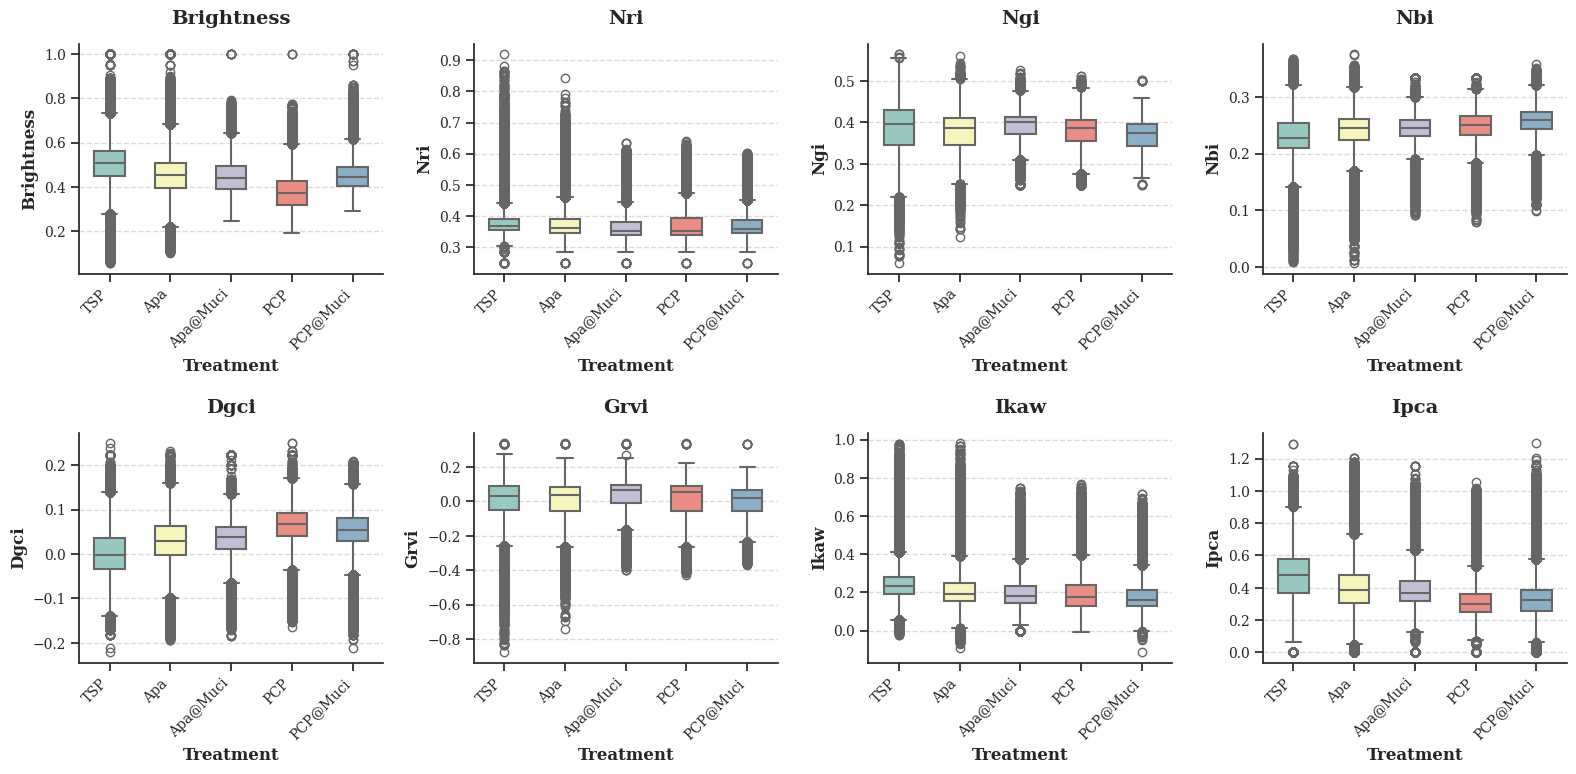

In [ ]:
def plot_individual_color_channels(df, output_path=None):
    """
    Create publication-quality plots of color indices for each treatment in a 4x4 grid.

    :param df: pandas DataFrame containing the image analysis results
    :param output_path: path to save the figure (optional)
    """
    # Create the figure and 2x4 axes grid
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    # fig.suptitle('Color Channel Distributions by Treatment', fontsize=16, fontweight='bold', y=0.95)

    indices = ['brightness', 'nri', 'ngi', 'nbi', 'dgci', 'grvi', 'Ikaw', 'Ipca']

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    for i, index in enumerate(indices):
        ax = axes[i]

        # Create the boxplot
        sns.boxplot(x='name', y=index, data=df.explode(index), ax=ax,
                    width=0.5, palette='Set3', linewidth=1.5)

        # Customize the plot
        ax.set_xlabel('Treatment', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'{index.capitalize()}', fontsize=12, fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Use scientific notation for y-axis if values are very small
        if np.max(np.abs(df[index].explode())) < 0.01:
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        # Add a subtle grid
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)

        # Add title to each subplot
        ax.set_title(f'{index.capitalize()}', fontsize=14, fontweight='bold', y=1.05)

    # Hide any remaining empty subplots
    for j in range(len(indices), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()

    # Save the figure if output_path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()

# Call the function to create and display the plot
plot_individual_color_channels(df, 'indices_boxplots.png')

<ipython-input-50-94bc0261d5b0>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=treatment_column, y=parameter, data=df_exploded, ax=ax,
<ipython-input-50-94bc0261d5b0>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


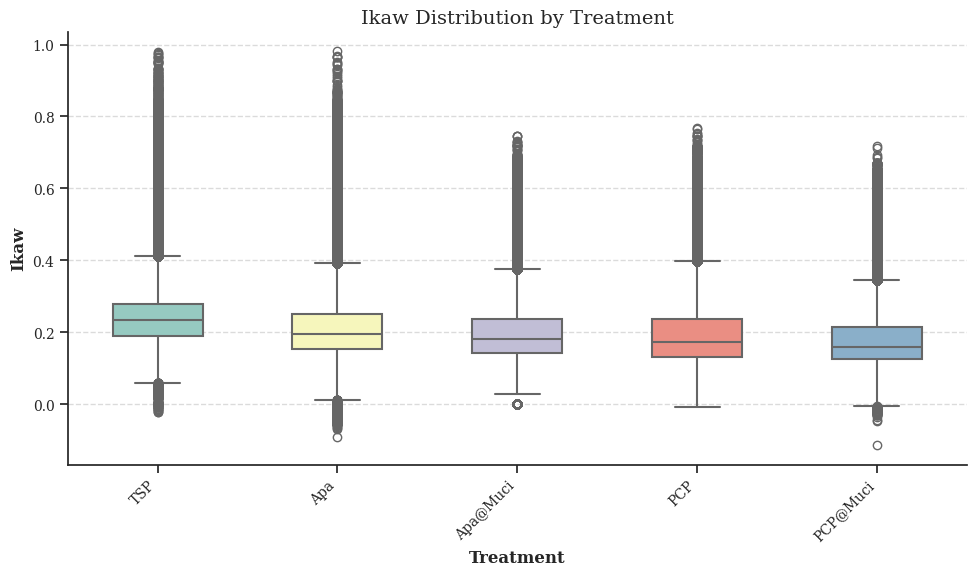

In [ ]:
def plot_treatment_vs_parameter(df, parameter, treatment_column='name', output_path=None):
    """
    Create a publication-quality boxplot of a specified parameter for each treatment.

    :param df: pandas DataFrame containing the image analysis results
    :param parameter: string, the name of the column to plot
    :param treatment_column: string, the name of the column containing treatments (default: 'name')
    :param output_path: path to save the figure (optional)
    """
    # Create a new DataFrame with exploded arrays
    df_exploded = pd.DataFrame({
        treatment_column: df[treatment_column].repeat(df[parameter].apply(len)),
        parameter: np.concatenate(df[parameter].values)
    })

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the boxplot
    sns.boxplot(x=treatment_column, y=parameter, data=df_exploded, ax=ax,
                width=0.5, palette='Set3', linewidth=1.5)

    # Customize the plot
    ax.set_xlabel('Treatment', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{parameter.capitalize()}', fontsize=12, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Use scientific notation for y-axis if values are very small
    if np.max(np.abs(df_exploded[parameter])) < 0.01:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # Add a subtle grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Add title to the plot
    plt.title(f'{parameter.capitalize()} Distribution by Treatment', fontsize=14)

    # Adjust layout
    plt.tight_layout()

    # Save the figure if output_path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()

# Example usage:
plot_treatment_vs_parameter(df, 'Ikaw', 'name', 'Ikaw_boxplot.png')

In [ ]:
def reshape_for_export(df, column_name):
    """
    Reshape the DataFrame for a specific column, creating a new DataFrame
    suitable for export to statistical software.

    :param df: pandas DataFrame containing the original data
    :param column_name: str, name of the column to reshape
    :return: pandas DataFrame with 'name' and f'value_{column_name}' columns
    """
    # Create a new DataFrame
    reshaped_df = pd.DataFrame({
        'name': df['name'].repeat(df[column_name].apply(len)),
        f'value_{column_name}': df[column_name].explode()
    })

    # Reset the index
    reshaped_df = reshaped_df.reset_index(drop=True)

    return reshaped_df

# Example usage:
folder_path_csv = '/content/drive/MyDrive/Phosphorus_project/Cropped_Images/Stats_CSVs/'

# Function to reshape and export multiple columns
def reshape_and_export_multiple(df, column_names, output_prefix='reshaped'):
    """
    Reshape and export multiple columns from the DataFrame.

    :param df: pandas DataFrame containing the original data
    :param column_names: list of str, names of the columns to reshape and export
    :param output_prefix: str, prefix for the output CSV files
    """
    for column in column_names:
        reshaped = reshape_for_export(df, column)
        output_filename = f'{output_prefix}_{column}_for_stats.csv'
        reshaped.to_csv(folder_path_csv + output_filename, index=False)
        print(f"Exported {output_filename}")

# Example usage:
columns_to_export = ['red','green','blue','hue', 'saturation', 'value','brightness', 'nri', 'ngi', 'nbi', 'dgci', 'grvi', 'ikaw', 'ipca']
reshape_and_export_multiple(df, columns_to_export)

Exported reshaped_red_for_stats.csv
Exported reshaped_green_for_stats.csv
Exported reshaped_blue_for_stats.csv
Exported reshaped_hue_for_stats.csv
Exported reshaped_saturation_for_stats.csv
Exported reshaped_value_for_stats.csv
Exported reshaped_brightness_for_stats.csv
Exported reshaped_nri_for_stats.csv
Exported reshaped_ngi_for_stats.csv
Exported reshaped_nbi_for_stats.csv
Exported reshaped_dgci_for_stats.csv
Exported reshaped_grvi_for_stats.csv
Exported reshaped_ikaw_for_stats.csv
Exported reshaped_ipca_for_stats.csv
